In [1]:
import os
import requests
from PIL import Image, ImageDraw
from io import BytesIO
import pandas as pd
import cairosvg
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import json
from tqdm import tqdm
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

2024-11-07 07:54:52.192927: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 07:54:52.368288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 07:54:52.430514: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 07:54:52.448931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 07:54:52.585992: I tensorflow/core/platform/cpu_feature_guar

In [2]:
DS_PATH = "../ds"
DS_ENTRY = f"{DS_PATH}/Poses.json"
OUTPUT_DIR_IMG_SVG="simple_images_png"
OUTPUT_DIR_AUGMENT_IMG_SIMPLE = "augment_simple_img"
OUTPUT_DIR_AUGMENT_IMG_REAL = "augment_real_img"

In [3]:
%load_ext tensorboard

# 1. Carga de datos

### 1.1 Datos Json

In [4]:

# Download if folder was not present
if not os.path.exists(DS_PATH):
    os.system(
        f"kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset -p {DS_PATH} --unzip"
    )

with open(DS_ENTRY, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data["Poses"])

df.head()

,id,sanskrit_name,english_name,img_url
0,1,Navasana,Boat,https://www.dropbox.com/s/4m64ztxkj8a4dab/boat...
1,2,Ardha Navasana,Half-Boat,https://www.dropbox.com/s/1nx0r94msxjwvyp/boat...
2,3,Dhanurasana,Bow,https://www.dropbox.com/s/wizj5kwxvez4c0a/bow....
3,4,Setu Bandha Sarvangasana,Bridge,https://www.dropbox.com/s/f1w64ybg4sn8ejt/brid...
4,5,Baddha Konasana,Butterfly,https://www.dropbox.com/s/3h2pts6xbn28dh7/butt...


### 1.2 Descarga y converison de los svg

In [5]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocesa una imagen para ser utilizada en una red neuronal.
    - Redimensiona la imagen al tamaño deseado.
    - Normaliza los valores de los píxeles entre 0 y 1.

    Args:
        image_path (str): Ruta de la imagen a preprocesar.
        target_size (tuple): Tamaño al cual redimensionar la imagen (ancho, alto).

    Returns:
        Image: Imagen preprocesada lista para ser usada en la red neuronal.
    """
    try:
        # Abrir la imagen
        img = Image.open(image_path)
        
        # Redimensionar la imagen al tamaño objetivo
        img = img.resize(target_size)
        
        # Convertir la imagen a un array de numpy y normalizar los valores de píxeles entre 0 y 1
        img_array = np.array(img) / 255.0
        
        # Convertir nuevamente a imagen con los valores normalizados
        img = Image.fromarray((img_array * 255).astype(np.uint8))
        
        return img
    except Exception as e:
        print(f"Error preprocesando la imagen {image_path}: {e}")
        return None

def plot_data_distribution(data_dir):
    """
    Grafica la distribución de las imágenes en cada clase para comprobar si el conjunto de datos está balanceado.

    Args:
        data_dir (str): Directorio donde están almacenadas las imágenes originales.
    """
    labels = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            labels.append(label)

    class_counts = {label: len(os.listdir(os.path.join(data_dir, label))) for label in labels}
    
    # Graficar la distribución de datos
    plt.figure(figsize=(10, 5))
    plt.barh(list(class_counts.keys()), list(class_counts.values()))
    plt.xlabel('Número de Imágenes')
    plt.ylabel('Clases')
    plt.title('Distribución de Imágenes por Clase')
    plt.tight_layout()
    plt.show()

    return class_counts



def download_and_convert_images(df, output_dir="images"):
    """
    Descarga las imágenes desde las URLs del DataFrame, las convierte a PNG, las preprocesa y las guarda con el nombre basado en sanskrit_name.

    Args:
        df (DataFrame): DataFrame que contiene las columnas 'english_name' y 'img_url'.
        output_dir (str): Directorio donde se guardarán las imágenes.
    """
    # Iterar sobre cada fila del DataFrame
    for index, row in df.iterrows():
        english_name = row['sanskrit_name']#.replace(" ", "_").lower()  # Reemplazar espacios por guiones bajos y poner en minúsculas
        img_url = row['img_url']
        
        # Crear el directorio de salida específico para cada etiqueta si no existe
        label_dir = os.path.join(output_dir, english_name)
        if os.path.exists(label_dir):
            print(f"El directorio {label_dir} ya existe, se omite el procesamiento para esta etiqueta.")
            continue
        else:
            os.makedirs(label_dir)
        
        try:
            # Descargar la imagen desde la URL
            response = requests.get(img_url, stream=True)
            response.raise_for_status()
            
            # Verificar que la respuesta sea de tipo imagen/svg
            if 'image/svg+xml' in response.headers.get('Content-Type', ''):
                # Convertir la imagen SVG a PNG directamente usando cairosvg
                png_output_path = os.path.join(label_dir, f"{english_name}.png")
                cairosvg.svg2png(bytestring=response.content, write_to=png_output_path)
                
                # Preprocesar la imagen
                preprocessed_image = preprocess_image(png_output_path)
                if preprocessed_image is not None:
                    # Guardar la imagen preprocesada en formato PNG
                    preprocessed_image.save(png_output_path, "PNG")
                    print(f"Imagen preprocesada guardada: {png_output_path}")
                else:
                    print(f"Error al preprocesar la imagen: {png_output_path}")
            else:
                print(f"La URL no contiene una imagen SVG: {img_url}")
        except requests.exceptions.RequestException as e:
            print(f"Error descargando {img_url}: {e}")
        except Exception as e:
            print(f"Error procesando la imagen {english_name}: {e}")

def augment_images(data_dir, augment_dir, augment_needed, datagen, target_size=(224, 224)):
    """
    Función genérica para aumentar las imágenes disponibles creando múltiples versiones con transformaciones y añadiendo fondos aleatorios.

    Args:
        data_dir (str): Directorio donde están almacenadas las imágenes originales.
        augment_dir (str): Directorio donde se guardarán las imágenes aumentadas.
        augment_needed (int): Número de imágenes que cada clase debe alcanzar mediante aumentación.
        datagen (ImageDataGenerator): Generador de aumentación de imágenes.
        target_size (tuple): Tamaño al cual redimensionar las imágenes (ancho, alto).
    """
    # Iterar sobre cada carpeta de categoría en el directorio de datos con barra de progreso
    for label in tqdm(os.listdir(data_dir), desc="Aumentando imágenes por clase"):
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir) or label.startswith('.ipynb_checkpoints'):
            continue

        # Crear la carpeta de destino para las imágenes aumentadas si no existe
        augment_label_dir = os.path.join(augment_dir, label)
        if not os.path.exists(augment_label_dir):
            os.makedirs(augment_label_dir)

        # Copiar las imágenes originales al directorio de aumentación y realizar preprocesamiento
        for img_name in os.listdir(label_dir):
            original_img_path = os.path.join(label_dir, img_name)
            copied_img_path = os.path.join(augment_label_dir, img_name)
            if not os.path.exists(copied_img_path):
                preprocessed_image = preprocess_image(original_img_path, target_size)
                if preprocessed_image is not None:
                    preprocessed_image.save(copied_img_path, "PNG")
                else:
                    print(f"Error al preprocesar la imagen original: {original_img_path}")

        # Obtener el número actual de imágenes en la clase
        current_count = len(os.listdir(augment_label_dir))
        total_needed = augment_needed - current_count

        if total_needed <= 0:
            print(f"La clase {label} ya tiene suficientes imágenes.")
            continue

        # Iterar sobre cada imagen en la carpeta de categoría hasta alcanzar el número necesario
        while total_needed > 0:
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                try:
                    img = Image.open(img_path).convert("RGBA")  # Convertir a RGBA para asegurar que tiene canal alfa
                    img = img.resize(target_size)

                    # Crear un fondo aleatorio para cada aumentación
                    background = Image.new("RGBA", target_size, (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), 255))
                    combined = Image.alpha_composite(background, img).convert("RGB")
                    img_array = np.array(combined)

                    # Verificar y ajustar la forma del array para asegurarse de que tiene las dimensiones correctas
                    if len(img_array.shape) == 2:  # Imágenes en escala de grises
                        img_array = np.stack((img_array,) * 3, axis=-1)  # Convertir a RGB duplicando los canales
                    elif img_array.shape[-1] != 3:  # Si no tiene 3 canales
                        print(f"Advertencia: La imagen {img_path} no tiene 3 canales. Se omite la aumentación.")
                        continue

                    img_array = img_array.reshape((1, target_size[0], target_size[1], 3)) / 255.0

                    # Generar una imagen aumentada y guardarla
                    for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augment_label_dir, save_prefix=label, save_format='png'):
                        total_needed -= 1
                        break
                    if total_needed <= 0:
                        break
                except Exception as e:
                    print(f"Error aumentando la imagen {img_path}: {e}")


def augment_images_based_on_distribution(data_dir="images", augment_dir="augmented_images", target_size=(224, 224), additional_count=100):
    """
    Aumenta las imágenes en cada clase basándose en la distribución actual.

    Args:
        data_dir (str): Directorio donde están almacenadas las imágenes originales.
        augment_dir (str): Directorio donde se guardarán las imágenes aumentadas.
        target_size (tuple): Tamaño al cual redimensionar las imágenes (ancho, alto).
        additional_count (int): Número adicional de imágenes a agregar en cada clase, además de igualar la clase con el mayor número de imágenes.
    """
    # Realizar aumentación solo si el directorio de imágenes aumentadas no existe
    if os.path.exists(augment_dir):
        print(f"El directorio {augment_dir} ya existe, se omite la aumentación de imágenes.")
        #return
    else:
        os.makedirs(augment_dir)

    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Obtener la distribución de clases
    class_counts = plot_data_distribution(data_dir)
    max_count = max(class_counts.values())
    augment_needed = max_count + additional_count

    # Iterar sobre cada carpeta de categoría en el directorio de datos
    # for label, count in class_counts.items():
    #     if label.startswith('.ipynb_checkpoints'):
    #         continue
    #     label_dir = os.path.join(data_dir, label)
    #     augment_label_dir = os.path.join(augment_dir, label)
    #     augment_images(label_dir, augment_label_dir, augment_needed, datagen, target_size)
    augment_images(data_dir, augment_dir, augment_needed, datagen, target_size)

El directorio simple_images_png/Navasana ya existe, se omite el procesamiento para esta etiqueta.
El directorio simple_images_png/Ardha Navasana ya existe, se omite el procesamiento para esta etiqueta.
El directorio simple_images_png/Dhanurasana ya existe, se omite el procesamiento para esta etiqueta.
El directorio simple_images_png/Setu Bandha Sarvangasana ya existe, se omite el procesamiento para esta etiqueta.
El directorio simple_images_png/Baddha Konasana ya existe, se omite el procesamiento para esta etiqueta.
El directorio simple_images_png/Ustrasana ya existe, se omite el procesamiento para esta etiqueta.
El directorio simple_images_png/Marjaryasana ya existe, se omite el procesamiento para esta etiqueta.
El directorio simple_images_png/Bitilasana ya existe, se omite el procesamiento para esta etiqueta.
El directorio simple_images_png/Utkatasana ya existe, se omite el procesamiento para esta etiqueta.
El directorio simple_images_png/Balasana ya existe, se omite el procesamiento

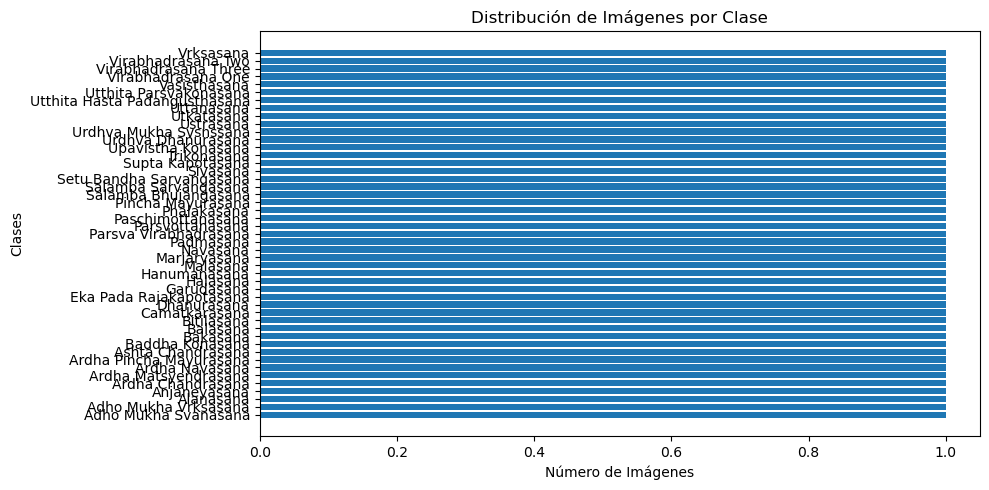

Aumentando imágenes por clase:  32%|███▏      | 15/47 [00:00<00:00, 71.99it/s]

La clase Adho Mukha Svanasana ya tiene suficientes imágenes.
La clase Adho Mukha Vrksasana ya tiene suficientes imágenes.
La clase Alanasana ya tiene suficientes imágenes.
La clase Anjaneyasana ya tiene suficientes imágenes.
La clase Ardha Chandrasana ya tiene suficientes imágenes.
La clase Ardha Matsyendrasana ya tiene suficientes imágenes.
La clase Ardha Navasana ya tiene suficientes imágenes.
La clase Ardha Pincha Mayurasana ya tiene suficientes imágenes.
La clase Ashta Chandrasana ya tiene suficientes imágenes.
La clase Baddha Konasana ya tiene suficientes imágenes.
La clase Bakasana ya tiene suficientes imágenes.
La clase Balasana ya tiene suficientes imágenes.
La clase Bitilasana ya tiene suficientes imágenes.
La clase Camatkarasana ya tiene suficientes imágenes.
La clase Dhanurasana ya tiene suficientes imágenes.


Aumentando imágenes por clase:  49%|████▉     | 23/47 [00:00<00:00, 75.00it/s]

La clase Eka Pada Rajakapotasana ya tiene suficientes imágenes.
La clase Garudasana ya tiene suficientes imágenes.
La clase Halasana ya tiene suficientes imágenes.
La clase Hanumanasana ya tiene suficientes imágenes.
La clase Malasana ya tiene suficientes imágenes.
La clase Marjaryasana ya tiene suficientes imágenes.
La clase Navasana ya tiene suficientes imágenes.
La clase Padmasana ya tiene suficientes imágenes.
La clase Parsva Virabhadrasana ya tiene suficientes imágenes.
La clase Parsvottanasana ya tiene suficientes imágenes.
La clase Paschimottanasana ya tiene suficientes imágenes.
La clase Phalakasana ya tiene suficientes imágenes.
La clase Pincha Mayurasana ya tiene suficientes imágenes.
La clase Salamba Bhujangasana ya tiene suficientes imágenes.
La clase Salamba Sarvangasana ya tiene suficientes imágenes.


Aumentando imágenes por clase:  83%|████████▎ | 39/47 [00:00<00:00, 69.48it/s]

La clase Setu Bandha Sarvangasana ya tiene suficientes imágenes.
La clase Sivasana ya tiene suficientes imágenes.
La clase Supta Kapotasana ya tiene suficientes imágenes.
La clase Trikonasana ya tiene suficientes imágenes.
La clase Upavistha Konasana ya tiene suficientes imágenes.
La clase Urdhva Dhanurasana ya tiene suficientes imágenes.
La clase Urdhva Mukha Svsnssana ya tiene suficientes imágenes.
La clase Ustrasana ya tiene suficientes imágenes.
La clase Utkatasana ya tiene suficientes imágenes.
La clase Uttanasana ya tiene suficientes imágenes.
La clase Utthita Hasta Padangusthasana ya tiene suficientes imágenes.
La clase Utthita Parsvakonasana ya tiene suficientes imágenes.
La clase Vasisthasana ya tiene suficientes imágenes.
La clase Virabhadrasana One ya tiene suficientes imágenes.
La clase Virabhadrasana Three ya tiene suficientes imágenes.
La clase Virabhadrasana Two ya tiene suficientes imágenes.


Aumentando imágenes por clase: 100%|██████████| 47/47 [00:00<00:00, 73.09it/s]


La clase Vrksasana ya tiene suficientes imágenes.


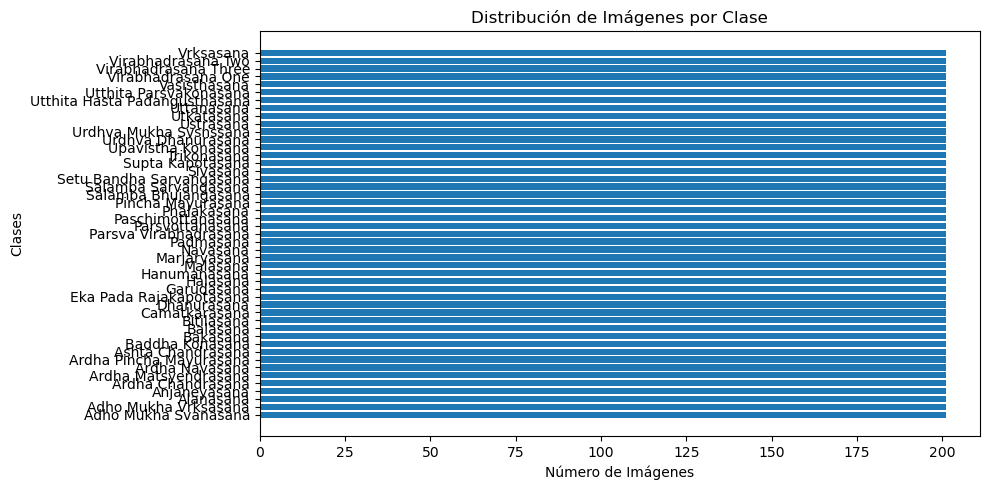

{'Adho Mukha Svanasana': 201,
 'Adho Mukha Vrksasana': 201,
 'Alanasana': 201,
 'Anjaneyasana': 201,
 'Ardha Chandrasana': 201,
 'Ardha Matsyendrasana': 201,
 'Ardha Navasana': 201,
 'Ardha Pincha Mayurasana': 201,
 'Ashta Chandrasana': 201,
 'Baddha Konasana': 201,
 'Bakasana': 201,
 'Balasana': 201,
 'Bitilasana': 201,
 'Camatkarasana': 201,
 'Dhanurasana': 201,
 'Eka Pada Rajakapotasana': 201,
 'Garudasana': 201,
 'Halasana': 201,
 'Hanumanasana': 201,
 'Malasana': 201,
 'Marjaryasana': 201,
 'Navasana': 201,
 'Padmasana': 201,
 'Parsva Virabhadrasana': 201,
 'Parsvottanasana': 201,
 'Paschimottanasana': 201,
 'Phalakasana': 201,
 'Pincha Mayurasana': 201,
 'Salamba Bhujangasana': 201,
 'Salamba Sarvangasana': 201,
 'Setu Bandha Sarvangasana': 201,
 'Sivasana': 201,
 'Supta Kapotasana': 201,
 'Trikonasana': 201,
 'Upavistha Konasana': 201,
 'Urdhva Dhanurasana': 201,
 'Urdhva Mukha Svsnssana': 201,
 'Ustrasana': 201,
 'Utkatasana': 201,
 'Uttanasana': 201,
 'Utthita Hasta Padangusth

In [11]:
download_and_convert_images(df,OUTPUT_DIR_IMG_SVG)
class_counts = plot_data_distribution(OUTPUT_DIR_IMG_SVG)
max_count_simple_class = max(class_counts.values())

datagen_simple_img = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
    )
augment_images(OUTPUT_DIR_IMG_SVG,OUTPUT_DIR_AUGMENT_IMG_SIMPLE,augment_needed=max_count_simple_class+200, datagen=datagen_simple_img)
plot_data_distribution(OUTPUT_DIR_AUGMENT_IMG_SIMPLE)

### 2 Entrenamiento de la CNN

In [6]:
def plot_metrics(history):
    """
    Grafica la pérdida y precisión del entrenamiento y validación.
    
    Parámetros:
    - history: objeto de historial devuelto por el método fit() de Keras.
    """
    # Crear la figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfica de Pérdida
    ax1.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    if('val_loss' in history.history):
        ax1.plot(history.history['val_loss'], label='Pérdida de Validación')
    ax1.set_title('Pérdida durante el Entrenamiento')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True)

    # Gráfica de Precisión
    ax2.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    if('val_accuracy' in history.history):
        ax2.plot(history.history['val_accuracy'], label='Precisión de Validación')
    ax2.set_title('Precisión durante el Entrenamiento')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True)

    # Mostrar la figura
    plt.show()

In [7]:
def build_functional_cnn_model(input_shape, num_classes):
    """
    Construye un modelo de red neuronal convolucional utilizando la API funcional de Keras.

    Args:
        input_shape (tuple): Forma de la entrada del modelo (altura, ancho, canales).
        num_classes (int): Número de clases para la clasificación.

    Returns:
        Model: Modelo de Keras compilado listo para ser entrenado.
    """
    # Definir la entrada
    inputs = layers.Input(shape=input_shape)

    # Primer bloque de capas
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.3)(x)

    # Segundo bloque de capas
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)   
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.3)(x)
    
    # Tercer bloque de capas
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)    
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.3)(x)

    # Cuarto bloque de capas
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)    
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.3)(x)

    # Cuarto bloque de capas
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)    
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.3)(x)

    # Global Average Pooling en lugar de Flatten para reducir parámetros
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)

    # Capa densa final con salida para la clasificación
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Definir el modelo
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.summary()
    return model

def train_cnn_with_augmentation(data_dir, target_size=(224, 224), batch_size=32, epochs=10):
    """
    Entrena una CNN usando las imágenes con aumentación para mejorar la generalización del modelo.

    Args:
        data_dir (str): Directorio donde están almacenadas las imágenes preprocesadas y aumentadas.
        target_size (tuple): Tamaño al cual redimensionar las imágenes (ancho, alto).
        batch_size (int): Tamaño del batch para el entrenamiento.
        epochs (int): Número de épocas para el entrenamiento.
    Returns:
        History: Objeto de historial de entrenamiento de Keras.
    """
    # Liberar memoria de la GPU antes de iniciar el entrenamiento
    tf.keras.backend.clear_session()

    # Generador de aumentación de imágenes
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        validation_split=0.2  # Dividir el conjunto de datos para validación
    )

    # Crear el generador para las imágenes de entrenamiento
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True  # Asegurar que los datos estén mezclados
    )

    # Crear el generador para las imágenes de validación
    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False  # Desactivar shuffle para validación
    )

    # Verificar que los generadores no estén vacíos
    if train_generator.samples == 0 or validation_generator.samples == 0:
        print("Error: No hay suficientes datos en los conjuntos de entrenamiento o validación.")
        return None

    # Construir el modelo usando la API funcional
    model = build_functional_cnn_model(input_shape=(target_size[0], target_size[1], 3), num_classes=train_generator.num_classes)

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    checkpoint_callback = ModelCheckpoint(
    'mejor_modelo_real_img.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
    )
    
    # Entrenar el modelo
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1, callbacks=[callback,tensorboard_callback,checkpoint_callback])
    
    # Devolver el historial de entrenamiento
    return history

In [8]:
# Clear any logs from previous runs

!rm -rf ./logs/
%tensorboard --logdir logs
history = train_cnn_with_augmentation(epochs = 20,batch_size=64,data_dir=OUTPUT_DIR_AUGMENT_IMG_SIMPLE)

Found 7567 images belonging to 47 classes.
Found 1880 images belonging to 47 classes.


I0000 00:00:1730966164.664759     178 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730966164.692206     178 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730966164.692271     178 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730966164.695073     178 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730966164.695121     178 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 112, 112, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 56, 56, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 28, 28, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 14, 14, 256)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,598,703 (6.10 MB)

 Trainable params: 1,595,695 (6.09 MB)

 Non-trainable params: 3,008 (11.75 KB)

/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1730966170.234298     773 service.cc:146] XLA service 0x7fa960004920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730966170.234358     773 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2024-11-07 07:56:10.354021: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-07 07:56:10.773308: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1730966183.331445     773 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 41/119 ━━━━━━━━━━━━━━━━━━━━ 31s 398ms/step - accuracy: 0.0236 - loss: 10.9887

2024-11-07 07:56:41.200452: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3867', 116 bytes spill stores, 116 bytes spill loads

2024-11-07 07:56:41.314884: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3862', 8 bytes spill stores, 8 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 89s 613ms/step - accuracy: 0.0301 - loss: 10.8342 - val_accuracy: 0.0213 - val_loss: 10.4615
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 57s 480ms/step - accuracy: 0.0498 - loss: 10.1643 - val_accuracy: 0.0213 - val_loss: 10.6613
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 57s 481ms/step - accuracy: 0.0644 - loss: 9.6826 - val_accuracy: 0.0250 - val_loss: 10.2898
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 58s 487ms/step - accuracy: 0.0754 - loss: 9.2685 - val_accuracy: 0.0346 - val_loss: 9.7202
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 57s 474ms/step - accuracy: 0.0930 - loss: 8.8336 - val_accuracy: 0.0734 - val_loss: 9.1561
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 58s 487ms/step - accuracy: 0.1104 - loss: 8.4597 - val_accuracy: 0.1080 - val_loss: 8.5384
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 58s 491ms/step - accuracy: 0.1371 - loss: 8.0538 - val_accuracy: 0.1404 - val_loss: 8.1011
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 57s 481ms/step - accuracy: 0.1443 - loss: 7.6986 

In [ ]:
plot_metrics(history)

## Carga y procesamiento de imagenes reales

In [ ]:
augment_images_based_on_distribution(DS_PATH, OUTPUT_DIR_AUGMENT_IMG_REAL, additional_count=max_count_simple_class+100)
class_counts = plot_data_distribution(OUTPUT_DIR_AUGMENT_IMG_REAL)

In [9]:
# Clear any logs from previous runs
!rm -rf ./logs/
%tensorboard --logdir logs
history = train_cnn_with_augmentation(epochs = 300,batch_size=64,data_dir=OUTPUT_DIR_AUGMENT_IMG_REAL)

Reusing TensorBoard on port 6006 (pid 533), started 0:21:28 ago. (Use '!kill 533' to kill it.)

Found 7423 images belonging to 47 classes.
Found 1833 images belonging to 47 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 112, 112, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 56, 56, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 28, 28, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 14, 14, 256)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,598,703 (6.10 MB)

 Trainable params: 1,595,695 (6.09 MB)

 Non-trainable params: 3,008 (11.75 KB)

Epoch 1/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 87s 694ms/step - accuracy: 0.0288 - loss: 10.7988 - val_accuracy: 0.0224 - val_loss: 10.2584
Epoch 2/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 62s 538ms/step - accuracy: 0.0363 - loss: 10.2424 - val_accuracy: 0.0213 - val_loss: 10.2805
Epoch 3/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 62s 531ms/step - accuracy: 0.0489 - loss: 9.8104 - val_accuracy: 0.0229 - val_loss: 10.0129
Epoch 4/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 63s 540ms/step - accuracy: 0.0466 - loss: 9.4349 - val_accuracy: 0.0344 - val_loss: 9.5189
Epoch 5/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 63s 539ms/step - accuracy: 0.0498 - loss: 9.1085 - val_accuracy: 0.0316 - val_loss: 8.8941
Epoch 6/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 63s 541ms/step - accuracy: 0.0520 - loss: 8.7477 - val_accuracy: 0.0415 - val_loss: 8.3871
Epoch 7/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 64s 553ms/step - accuracy: 0.0591 - loss: 8.3949 - val_accuracy: 0.0720 - val_loss: 7.9718
Epoch 8/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 64s 549ms/step - accuracy: 0.0

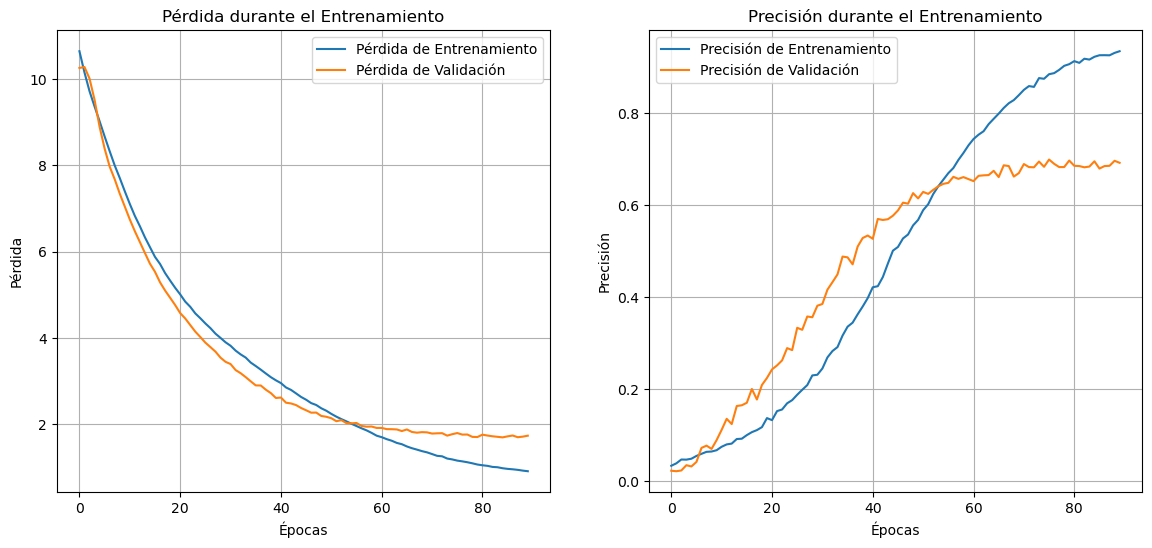

In [10]:
plot_metrics(history)

In [ ]:
# Cargar el modelo guardado en formato SavedModel
model = load_model('ruta_al_directorio/modelo_checkpoint')

# Continuar el entrenamiento desde la época deseada
model.fit(x_train, y_train, epochs=total_epochs, initial_epoch=80, validation_data=(x_val, y_val))